In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as opt
import csv

from scipy.linalg import expm
from scipy.optimize import minimize

import matplotlib
matplotlib.rcParams['figure.dpi'] = 50

In [138]:
#--- Static parameters and Hamiltonians ---
# Physical parameters (in MHz)
class PulseParameters:
    """
    Container for all static physical and derived pulse parameters, plus initial states and
    a time-grid generator.
    """
    def __init__(self,
                 Omega_Rabi1,
                 Omega_Rabi2,
                 blockade,
                 r_lifetime,
                 delta1,
                 delta2,
                 resolution,
                 optimizer: bool
                 ):
        # raw parameters
        self.Omega_Rabi1 = Omega_Rabi1
        self.Omega_Rabi2 = Omega_Rabi2
        self.blockade    = blockade
        self.r_lifetime  = r_lifetime
        self.delta1      = delta1
        self.delta2      = delta2
        self.resolution  = resolution
        self.optimizer   = optimizer

        assert self.optimizer in (0, 1), "optimizer must be 0 (not being run) or 1 (will be run)"

        self.recompute()
        
        # fixed initial state
        self.initial_psi01 = np.array([1, 0, 0], dtype=complex)
           
    # Dynamic initial parameters
    def recompute(self):
        """Re-derive normalized / derived parameters"""
        self.normalized_Omega = self.Omega_Rabi2 / self.Omega_Rabi1
        if self.blockade is not None: 
            self.normalized_blockade = self.blockade / self.Omega_Rabi1
            self.initial_psi11 = np.array([1, 0, 0, 0, 0, 0, 0], dtype=complex)
        else:
            self.normalized_blockade = self.blockade
            self.initial_psi11 = self.initial_psi01
        self.decay_rate = (1 / self.r_lifetime) / self.Omega_Rabi1
        assert self.optimizer in (0, 1), "optimizer must be 0 (not being run) or 1 (will be run)"
         
                    

    def time_grid(self, pulse_time):
        """
        Build a uniform time grid for a given pulse duration.
        Returns (times, dt).
        """
        times = np.linspace(0, pulse_time, self.resolution + 1)
        dt = times[1] - times[0]
        return times, dt


class Hamiltonians:
    """
    Provides Hamiltonian constructors given pulse parameters.
    """
    def __init__(self, params: PulseParameters):
        self.params = params

    def H11(self, phase_i):
        """Two-atom Hamiltonian at a given phase (Hermitian)."""
        Omega1 = np.exp(1j * phase_i)
        Omega2 = self.params.normalized_Omega * Omega1
        Delta1 = self.params.delta1
        Delta2 = self.params.delta2
        B  = self.params.normalized_blockade
        if B is None:
            H = np.sqrt(2)*self.H01(phase_i)
        else:
            H = 0.5 * np.sqrt(2) * np.array([
                [0,               Omega1,          Omega2,          0,            0,                   0,                   0],
                [np.conj(Omega1), Delta1,          0,               Omega1,       Omega2,              0,                   0],
                [np.conj(Omega2), 0,               Delta2,          0,            0,                   Omega1,              Omega2],
                [0,               np.conj(Omega1), 0,               2*Delta1 + B, 0,                   0,                   0],
                [0,               np.conj(Omega2), 0,               0,            Delta1 + Delta2 + B, 0,                   0],
                [0,               0,               np.conj(Omega1), 0,            0,                   Delta1 + Delta2 + B, 0],
                [0,               0,               np.conj(Omega2), 0,            0,                   0,                   2*Delta2 + B]
        ], complex)
        if self.params.optimizer == 0:
            H += (-1j * self.params.decay_rate / 2) * np.eye(H.shape[0])
        return H

    def H01(self, phase_i):
        """Single-atom Hamiltonian at a given phase (Hermitian)."""
        Omega1 = np.exp(1j * phase_i)
        Omega2 = self.params.normalized_Omega * Omega1
        Delta1 = self.params.delta1
        Delta2 = self.params.delta2

        H = 0.5 * np.array([
            [0,               Omega1,      Omega2],
            [np.conj(Omega1),     Delta1,      0 ],
            [np.conj(Omega2),     0,       Delta2]
        ], complex)
        if self.params.optimizer == 0:
            H += (-1j * self.params.decay_rate / 2) * np.eye(H.shape[0])
        return H
    
    # Derivative of H11_control w.r.t. phase
    def dH11_dphi(self, phase_i):
        assert self.params.normalized_blockade != None, "Cannot perform GRAPE with infinite blockade yet"
        Omega1 = np.exp(1j * phase_i)
        Omega2 = self.params.normalized_Omega * Omega1
        dOmega1 = 1j * Omega1
        dOmega2 = 1j * Omega2
        dH = 0.5 * np.sqrt(2) * np.array([
            [0,                dOmega1,          dOmega2,          0,                    0,                    0,                    0],
            [np.conj(dOmega1), 0,                0,                dOmega1,              dOmega2,              0,                    0],
            [np.conj(dOmega2), 0,                0,                0,                    0,              dOmega1,              dOmega2],
            [0,                np.conj(dOmega1), 0,                0,                    0,                    0,                    0],
            [0,                np.conj(dOmega2), 0,                0,                    0,                    0,                    0],
            [0,                0,                np.conj(dOmega1), 0,                    0,                    0,                    0],
            [0,                0,                np.conj(dOmega2), 0,                    0,                    0,                    0]
        ], complex)
        return dH

    # Derivative of H01_control w.r.t. phase
    def dH01_dphi(self, phase_i):
        Omega1 = np.exp(1j * phase_i)
        Omega2 = self.params.normalized_Omega * Omega1
        dOmega1 = 1j * Omega1
        dOmega2 = 1j * Omega2
        dH = 0.5 * np.array([
            [0,               dOmega1,      dOmega2],
            [np.conj(dOmega1),0,            0     ],
            [np.conj(dOmega2),0,            0     ]
        ], complex)
        return dH

class FidelityCalculator:
    """
    Computes fidelities for given quantum states.
    """
    @staticmethod
    def bell_state_fidelity(psi01, psi11):
        """Compute Bell state fidelity from single- and two-atom amplitudes."""
        return (1/16) * np.abs(1 + 2 * psi01[0] - psi11[0])**2
    

class CosineAnsatz:
    def generate(self, params: PulseParameters, inputs: np.ndarray):
        # unpack
        pulse_time, drive_detuning = inputs[0], inputs[1]
        A1, f1, o1, A2, f2, o2, A3, f3, o3 = inputs[2:]
        
        N = params.resolution
        # 1) Phase grid exactly as your inline: resolution points from 0 to T
        t_grid = np.linspace(0, pulse_time, N)
        # 2) timestep for simulation
        dt = pulse_time / N

        # build each cosine
        cos1 = np.cos((t_grid - pulse_time/2) * (f1 / params.Omega_Rabi1) - o1)
        cos2 = np.cos((t_grid - pulse_time/2) * (f2 / params.Omega_Rabi1) - o2)
        cos3 = np.cos((t_grid - pulse_time/2) * (f3 / params.Omega_Rabi1) - o3)

        # assemble phases
        phases = (drive_detuning / params.Omega_Rabi1) * t_grid \
               + A1 * cos1 * cos3 \
               + A2 * cos2 * cos3

        return phases, dt


#--- CRAB Optimizer ---
class GateSimulator:
    """
    Evolves the two-level system under a given phase profile and returns fidelity.
    """
    def __init__(self,
                 params: PulseParameters,
                 hams: Hamiltonians,
                 fidelity_calc: FidelityCalculator
                 ):
        self.params = params
        self.hams   = hams
        self.fid    = fidelity_calc

    def run(self, phases: np.ndarray, dt: float) -> float:
        psi01 = self.params.initial_psi01.copy()
        psi11 = self.params.initial_psi11.copy()
        for phi in phases:
            U01 = scipy.linalg.expm(-1j*self.hams.H01(phi)*dt)
            U11 = scipy.linalg.expm(-1j*self.hams.H11(phi)*dt)
            psi01 = U01 @ psi01
            psi11 = U11 @ psi11
        # remove global phase
        gp = psi01[0]/np.abs(psi01[0])
        psi01 /= gp
        psi11 /= gp**2
        return self.fid.bell_state_fidelity(psi01, psi11)


class CRABOptimizer:
    """
    Wraps a CosineAnsatz and GateSimulator to tune ansatz parameters via SciPy.
    """
    def __init__(self,
                 ansatz: CosineAnsatz,
                 simulator: GateSimulator
                 ):
        self.ans   = ansatz
        self.sim   = simulator

    def loss(self, inputs: np.ndarray) -> float:
        phases, dt = self.ans.generate(self.sim.params, inputs)
        F = self.sim.run(phases, dt)
        return 1 - F

    def optimize(self, init_inputs: np.ndarray):
        def cb(xk):
            inf = self.loss(xk)
            print(f"Infidelity: {inf:.6f}", end="\r", flush=True)
        res = minimize(self.loss, init_inputs, callback=cb, options={'gtol':1e-6})
        return res.fun, res.x


#--- GRAPE Optimizer ---
class GRAPEProfile:
    def __init__(self, params: PulseParameters):
        self.params = params

    def load(self, times_crab: np.ndarray, phi_crab: np.ndarray):
        # MUST be the exact used in CosineAnsatz
        self.times_crab = times_crab
        self.phi_crab   = phi_crab

    def interpolate(self, pulse_time: float, N: int):
        # build the GRAPE grid
        self.N       = N
        self.t_grape = np.linspace(0, pulse_time, N)

        # compute dt
        self.dt      = self.t_grape[1] - self.t_grape[0]

        # interpolate the CRAB phi onto grid
        self.u       = np.interp(self.t_grape, self.times_crab, self.phi_crab)

        return self.u, self.dt



class GRAPEOptimizer:
    """
    Implements forward/backward propagation and gradient-based optimization (GRAPE).
    """
    def __init__(self,
                 profile: GRAPEProfile,
                 hams: Hamiltonians,
                 fid_calc: FidelityCalculator
                 ):
        self.profile = profile
        self.hams    = hams
        self.fid_calc = fid_calc

    def forward_propagation(self, u: np.ndarray):
        N = self.profile.N
        psi01 = np.zeros((N+1, 3), complex)
        psi11 = np.zeros((N+1, 7), complex)
        psi01[0] = self.profile.params.initial_psi01.copy()
        psi11[0] = self.profile.params.initial_psi11.copy()
        for j in range(N):
            U01 = scipy.linalg.expm(-1j*self.hams.H01(u[j])*self.profile.dt)
            U11 = scipy.linalg.expm(-1j*self.hams.H11(u[j])*self.profile.dt)
            psi01[j+1] = U01 @ psi01[j]
            psi11[j+1] = U11 @ psi11[j]
        return psi01, psi11

    def backward_propagation(self, u: np.ndarray, psi01_f, psi11_f):
        N = self.profile.N
        S = 1 + 2*psi01_f[0] - psi11_f[0]
        chi01 = np.zeros((N+1, 3), complex)
        chi11 = np.zeros((N+1, 7), complex)
        chi01[N] = (np.conj(S)/8) * np.array([1,0,0], complex)
        chi11[N] = (-np.conj(S)/16) * np.array([1,0,0,0,0,0,0], complex)
        for j in reversed(range(N)):
            U01 = scipy.linalg.expm(-1j*self.hams.H01(u[j])*self.profile.dt)
            U11 = scipy.linalg.expm(-1j*self.hams.H11(u[j])*self.profile.dt)
            chi01[j] = U01.conj().T @ chi01[j+1]
            chi11[j] = U11.conj().T @ chi11[j+1]
        return chi01, chi11

    def fidelity_and_gradient(self, u: np.ndarray):
        psi01, psi11 = self.forward_propagation(u)
        psi01_f, psi11_f = psi01[-1], psi11[-1]
        
        gp = psi01_f[0] / np.abs(psi01_f[0])  # <-- add these three lines
        psi01_f = psi01_f / gp
        psi11_f = psi11_f / gp**2
        S = 1 + 2*psi01_f[0] - psi11_f[0]
        F_bell  = self.fid_calc.bell_state_fidelity(psi01_f, psi11_f) #F_bell = np.abs(S)**2 / 16
        chi01, chi11 = self.backward_propagation(u, psi01_f, psi11_f)
        grad = np.zeros_like(u)
        for j in range(self.profile.N):
            g01 = 2 * np.imag(chi01[j].conj().T @ (self.hams.dH01_dphi(u[j]) @ psi01[j])) * self.profile.dt
            g11 = 2 * np.imag(chi11[j].conj().T @ (self.hams.dH11_dphi(u[j]) @ psi11[j])) * self.profile.dt
            grad[j] = g01 + g11
        return 1 - F_bell, -grad

    def optimize(self, u_init: np.ndarray, maxiter=200):
        history = []
        def cb(xk):
            inf, _ = self.fidelity_and_gradient(xk)
            history.append(inf)
            print(f"Infidelity: {inf:.6f}", end="\r", flush=True)
        result = minimize(lambda x: self.fidelity_and_gradient(x)[0],
                          u_init,
                          jac=lambda x: self.fidelity_and_gradient(x)[1],
                          method='L-BFGS-B',

                          options={'maxiter': maxiter, 'disp':True},
                          callback=cb)
        return result.fun, result.x, history


In [53]:
if __name__ == "__main__":
    # set up (Omega_Rabi1, Omega_Rabi2, blockade, r_lifetime, delta1, delta2, resolution, optimizer)
    params        = PulseParameters(2*np.pi*10, 2*np.pi*10, 2*np.pi*10, 12e6, 0, 2*np.pi*10, 200, 1)
    hams          = Hamiltonians(params)
    fid_calc      = FidelityCalculator()
    ansatz        = CosineAnsatz()
    simulator     = GateSimulator(params, hams, fid_calc)

    # initial guess: [pulse_time, drive_detuning, (A_i,f_i,o_i)] Amplitudes, Frequencies, phi_Offsets
    init = [
        6.7, 0,
        2*np.pi*0.1122, 1.043*params.Omega_Rabi1,   -0.7318,
        0.1,           1.043*params.Omega_Rabi1*2, -2.44,
        0.01,          1.043*params.Omega_Rabi1*4, -5.15,
        #0.01,          1.043*params.Omega_Rabi1*8, -0.5
    ]

    optimizer = CRABOptimizer(ansatz, simulator)
    best_inf, best_x = optimizer.optimize(np.array(init))
    print("\nBest infidelity:", best_inf)
    print("Best parameters:", best_x)


Infidelity: 0.000028
Best infidelity: 2.8142510552053857e-05
Best parameters: [ 9.48932906e+00  6.65762701e+00 -1.40571392e+00  6.31350116e+01
  1.57068007e+00  1.61104547e+00  1.35461908e+02 -1.57077405e+00
  1.00000000e-02  2.03915861e+02 -3.14167792e+00]


In [54]:
#Sanity check
pulse_time = best_x[0]
dt = pulse_time/params.resolution
phases, dt = ansatz.generate(params, best_x)
simulator = GateSimulator(params, hams, fid_calc)
infidelity_test = 1 - simulator.run(phases, dt)
print(f"\nInfidelity via GateSimulator: {infidelity_test:.6e}")


Infidelity via GateSimulator: 2.814251e-05


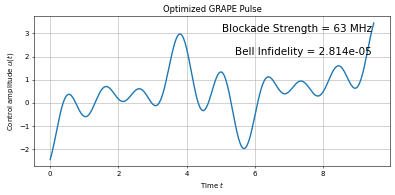

In [55]:
# --- Plot the optimized control pulse ---
t = np.linspace(0, pulse_time, params.resolution)

plt.figure(figsize=(8,4))
plt.plot(t, phases, lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Control amplitude $u(t)$')
plt.title('Optimized GRAPE Pulse')
plt.grid(True)
plt.tight_layout()
label = (f"Blockade Strength = {params.blockade:.0f} MHz\n\n"
         f"Bell Infidelity = {best_inf:.3e}")
plt.text(.95, 0.95, label, transform=plt.gca().transAxes,
         fontsize=15, verticalalignment='top', horizontalalignment='right')
plt.show()

In [56]:
# --- hand CRAB to GRAPE ----
profile = GRAPEProfile(params)

pulse_time = best_x[0]                                       # CRAB’s optimized T
times_crab = np.linspace(0, pulse_time, params.resolution)   # same grid as best CRAB
phi_crab, _ = ansatz.generate(params, best_x)                # optimized phases
profile.load(times_crab, phi_crab)
fid_calc = FidelityCalculator()

N=1000
u_init, dt = profile.interpolate(pulse_time, N)         # GRAPE starting guess
grape_opt  = GRAPEOptimizer(profile, hams, fid_calc)

infid, u_opt, history = grape_opt.optimize(u_init)
print(f"\nOptimized GRAPE infidelity: {infid:.6e}")


Infidelity: 0.000694
Optimized GRAPE infidelity: 6.935619e-04


In [151]:
#Sanity check
R = len(u_opt)
times_grape = np.linspace(0, pulse_time, R+1)
dt = times_grape[1]-times_grape[0]
simulator = GateSimulator(params, hams, fid_calc)
infidelity_test = 1 - simulator.run(u_opt, dt)
print(f"\nInfidelity via GateSimulator: {infidelity_test:.6e}")


Infidelity via GateSimulator: 5.796569e-04


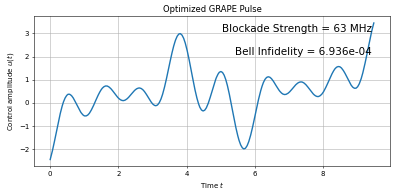

In [58]:
# --- Plot the optimized control pulse ---
t = np.linspace(0, pulse_time, N)

plt.figure(figsize=(8,4))
plt.plot(t, u_opt, lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Control amplitude $u(t)$')
plt.title('Optimized GRAPE Pulse')
plt.grid(True)
plt.tight_layout()
label = (f"Blockade Strength = {params.blockade:.0f} MHz\n\n"
         f"Bell Infidelity = {infid:.3e}")
plt.text(.95, 0.95, label, transform=plt.gca().transAxes,
         fontsize=15, verticalalignment='top', horizontalalignment='right')
plt.show()

In [156]:
params        = PulseParameters(2*np.pi*10, 2*np.pi*10, 2*np.pi*10, 12e6, 0, 2*np.pi*10, 200, 1)
hams          = Hamiltonians(params)
simulator = GateSimulator(params, hams, fid_calc)


In [161]:
#test with infinite blockade
params.blockade = 12e6
params.recompute()
inf_B_infid_test = 1 - simulator.run(u_opt, dt)
print(f"\nInfidelity via GateSimulator (infinite Blockade): {inf_B_infid_test:.6e}")


Infidelity via GateSimulator (infinite Blockade): 3.406633e-01


In [154]:
params.blockade = 10*2*np.pi
params.optimizer = 0
for tau in [10, 1, 0.5, 0.2, 0.05]: # µs
    params.r_lifetime = tau
    params.recompute()
    infid = 1 - simulator.run(u_opt, dt)
    print(f"τ = {tau:4.2g} µs  →  infidelity = {infid:.4e}")

τ =   10 µs  →  infidelity = 1.1825e-02
τ =    1 µs  →  infidelity = 1.0663e-01
τ =  0.5 µs  →  infidelity = 1.9966e-01
τ =  0.2 µs  →  infidelity = 4.1639e-01
τ = 0.05 µs  →  infidelity = 8.2730e-01
